In [1]:
from google.colab import drive
from google.colab import drive
import os

drive = drive.mount('/content/drive')
working_dir = '/content/drive/MyDrive/Colab_Notebooks/llm'
os.chdir(working_dir)

with open('train.txt','r',encoding='utf-8') as f:
    lines = f.readlines()

train_datas = []
temp_data = ''
for line in lines:

    if line!='\n': # line break
        line = line.strip()
        temp_data+=(line+'\t')
    else:
        train_datas.append(temp_data)
        temp_data=''

## small len datasets for simple traninning
train_datas = sorted(train_datas,key=lambda x:len(x))
new_train_datas = []
for train_data in train_datas:
    if len(train_data)<300:
        new_train_datas.append(train_data)

new_train_datas = new_train_datas[:10000]


with open('dataset.txt','w',encoding='utf-8') as f:
    for train_data in new_train_datas:
        f.write(train_data+'\n')



Mounted at /content/drive


In [2]:
print(len(new_train_datas))

10000


In [3]:
import json
# return freq of each word
def get_dict(datas):
    word_count ={}
    for data in datas: # each line
        data = data.strip().replace('\t','')
        for word in data: #each word
            word_count.setdefault(word,0) # if no key:word in dic , add key and set default value 0
            word_count[word]+=1 # count freq
    word2id = {"<pad>":0,"<unk>":1,"<sep>":2}

    temp = {word: i + len(word2id) for i, word in enumerate(word_count.keys())} # word to index
    word2id.update(temp)
    id2word=list(word2id.keys())
    return word2id,id2word



with open('dataset.txt','r',encoding='utf-8') as f:
    datas = f.readlines()
word2id, id2word = get_dict(datas)

dict_datas = {"word2id":word2id,"id2word":id2word}

json.dump(dict_datas, open('dict_datas.json', 'w', encoding='utf-8'))


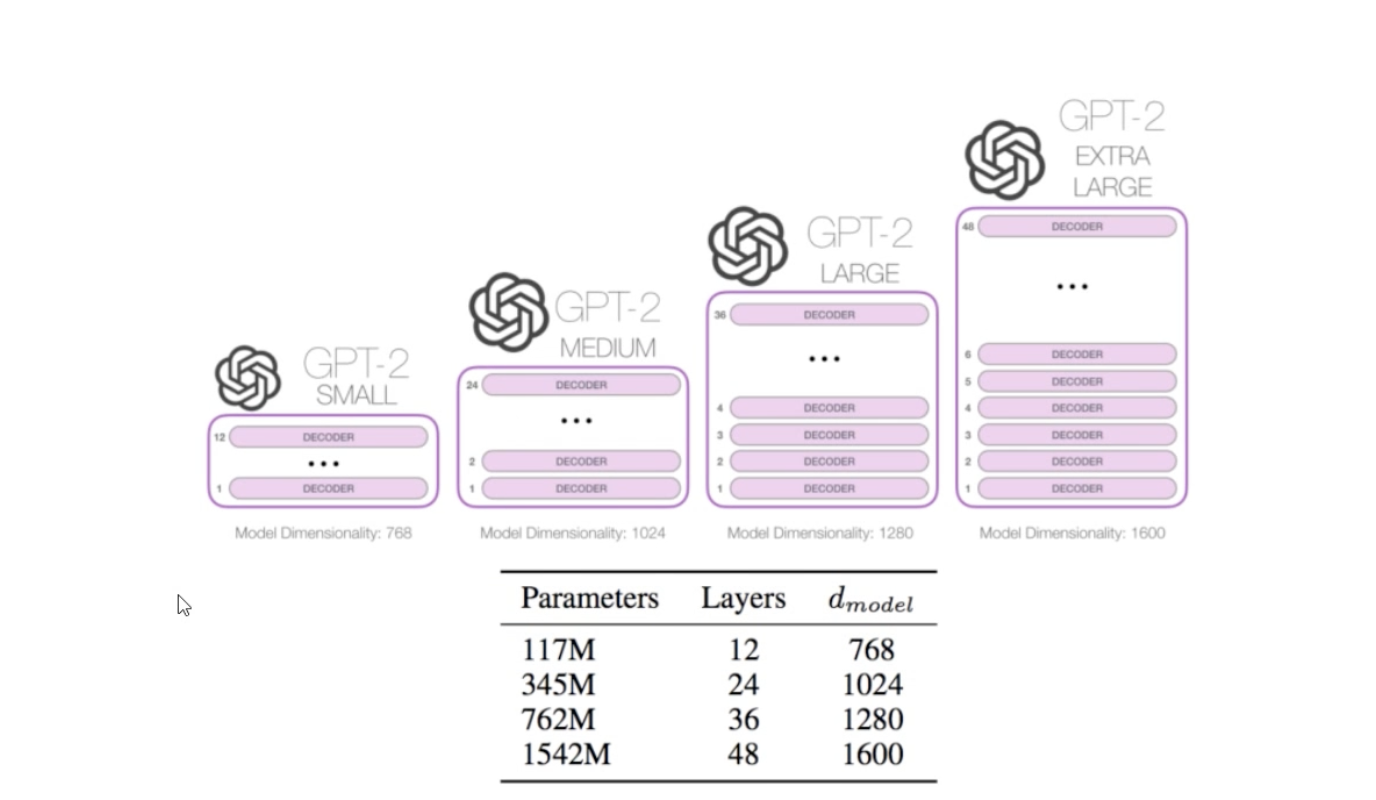

GPT-2 small with 12 decoder the size is almost 1B
There we use 6 layer

1.
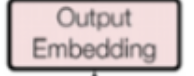

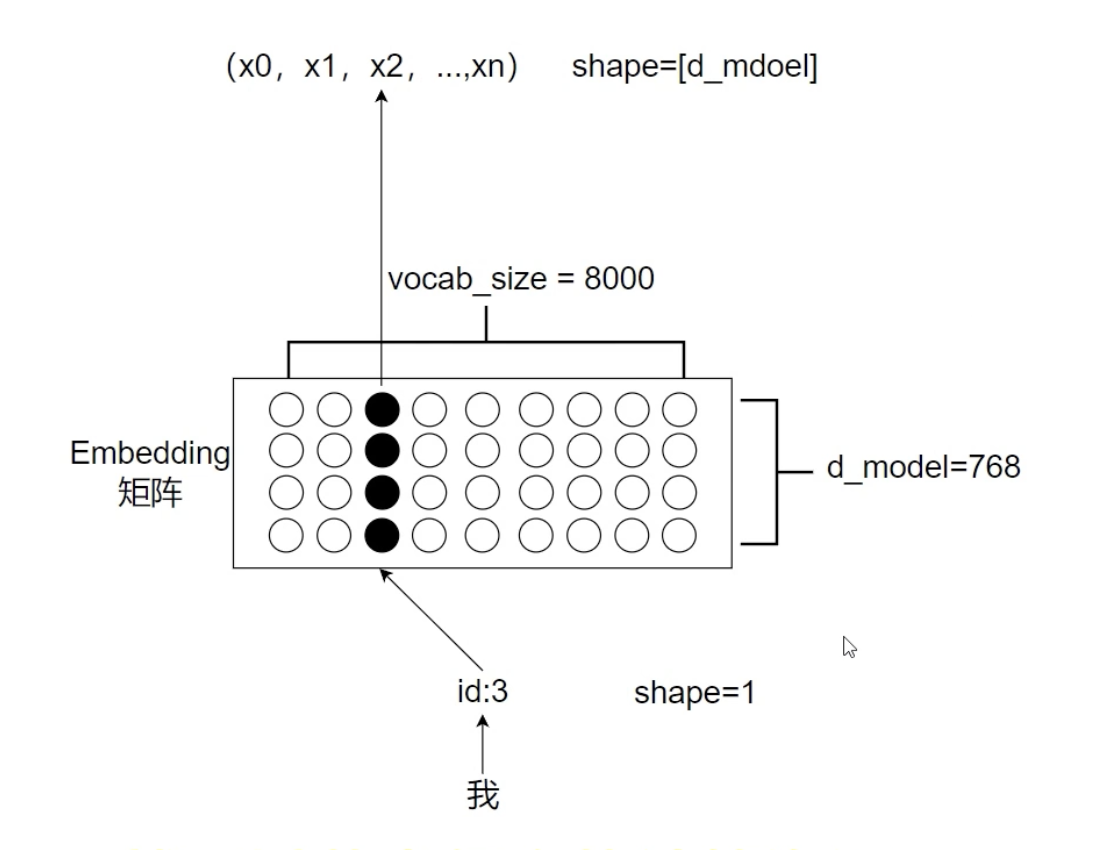

2.
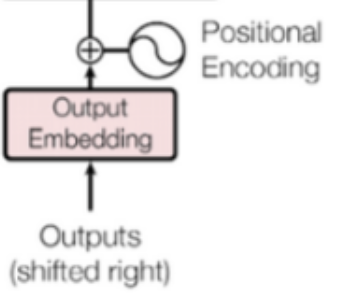

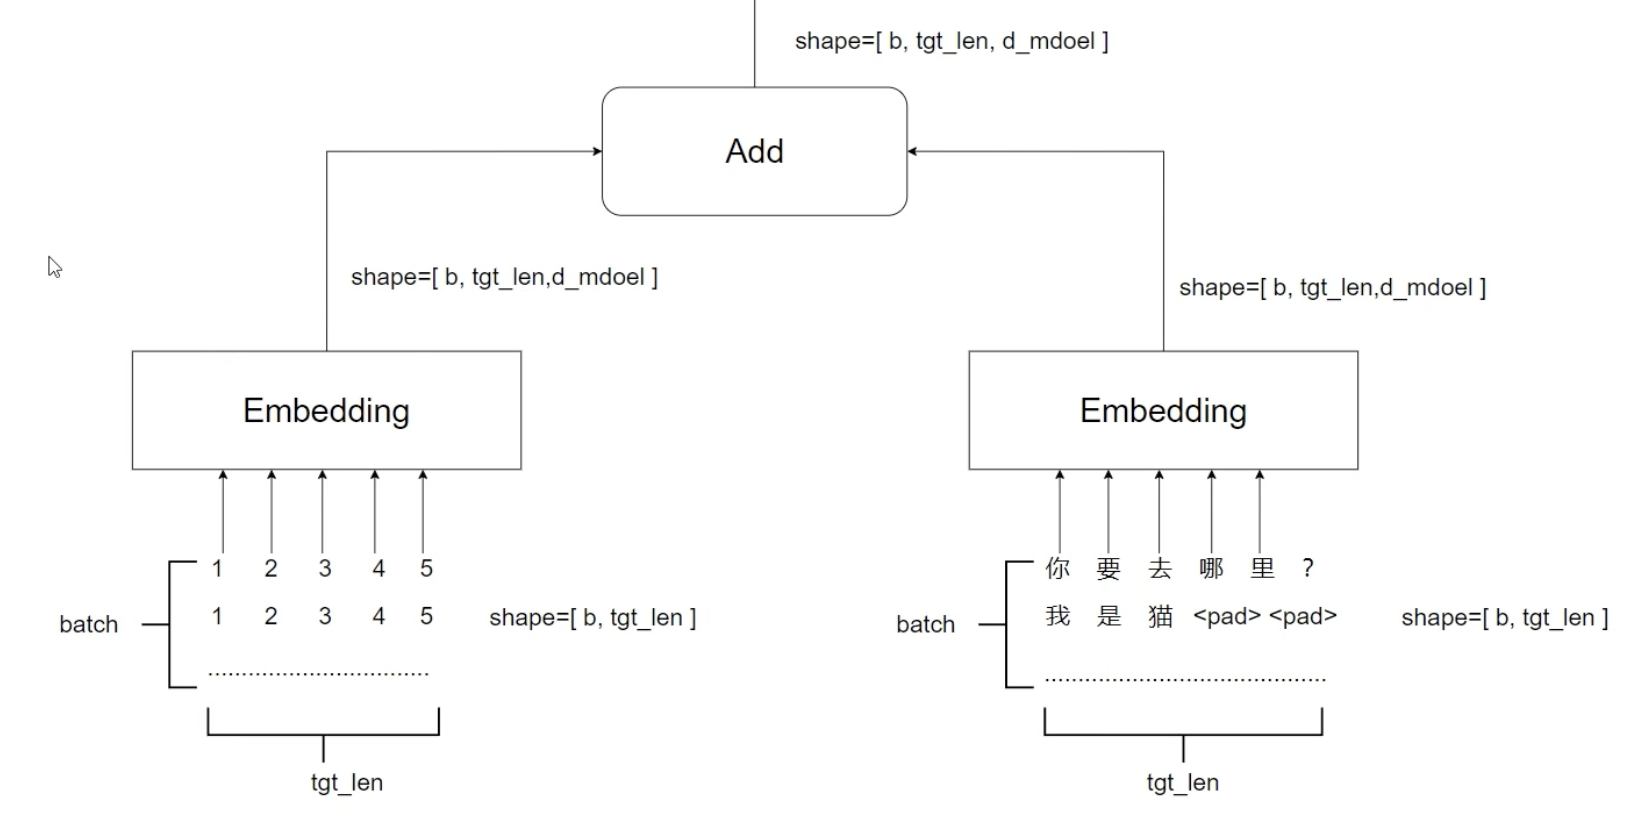

3.
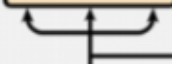

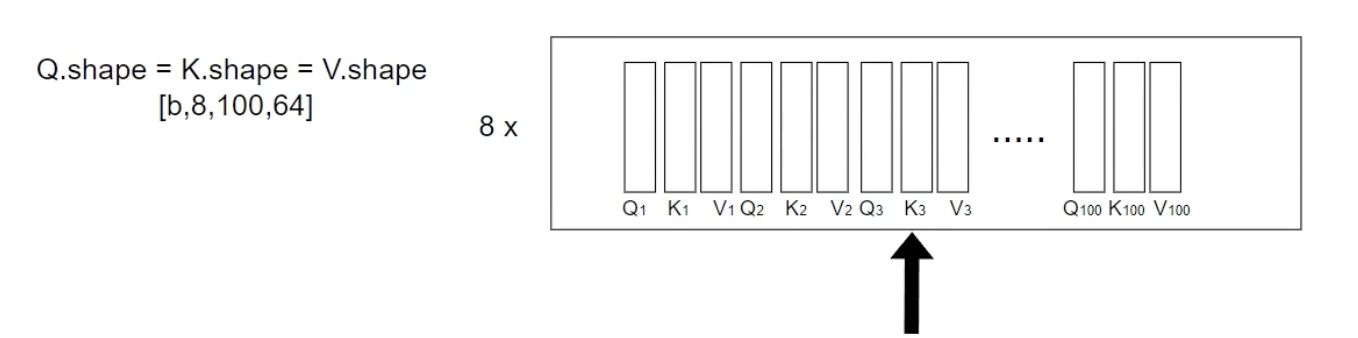

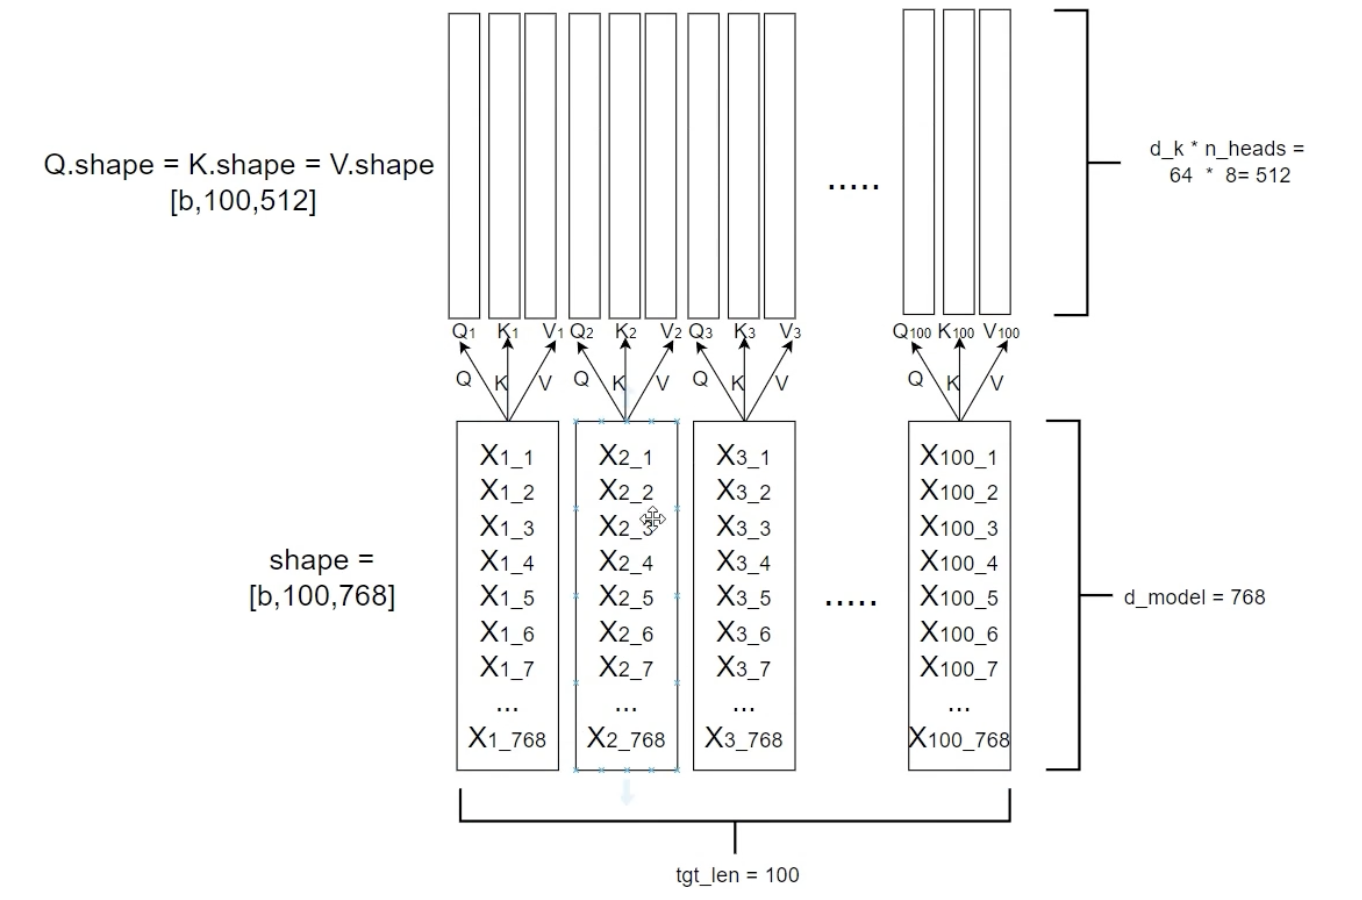

4.
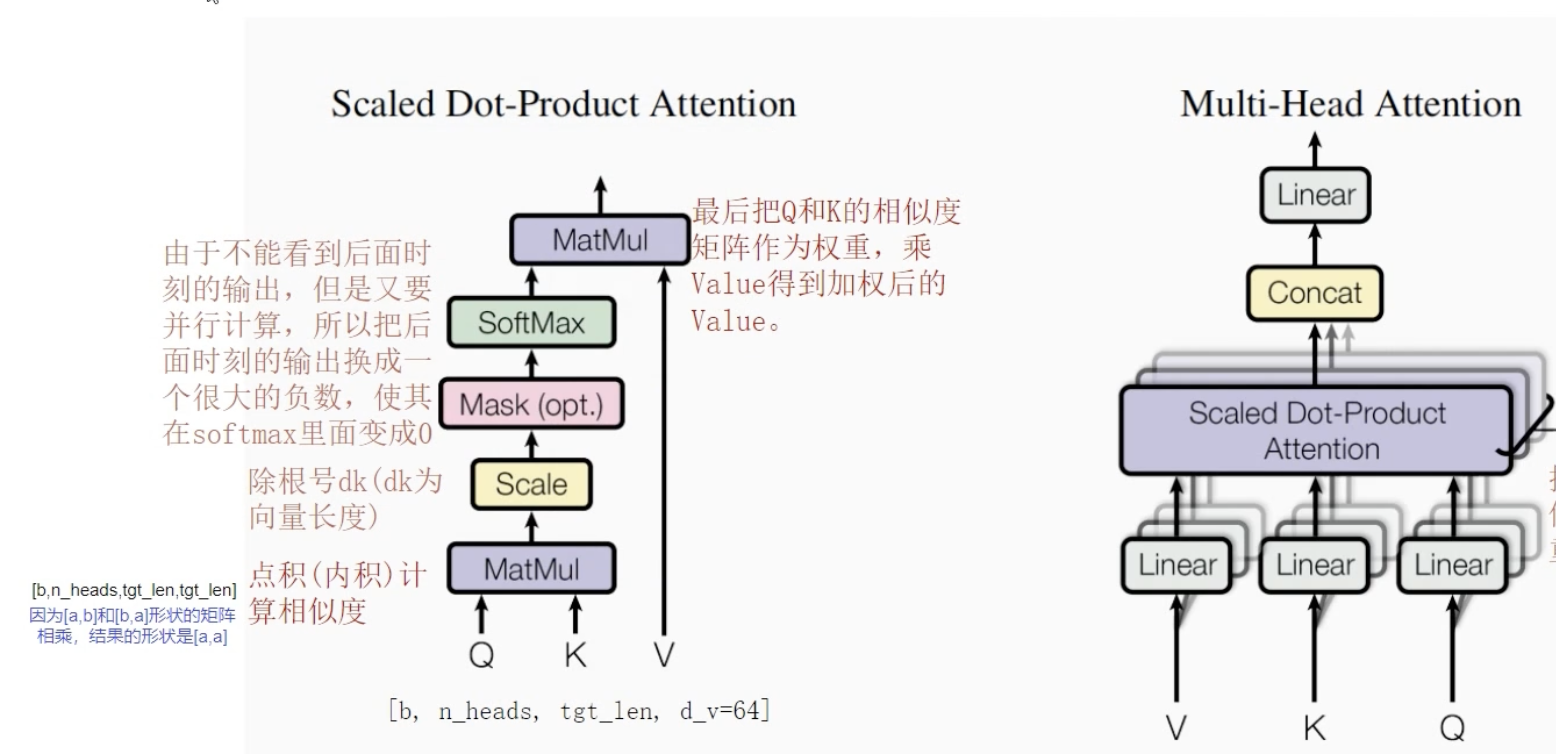

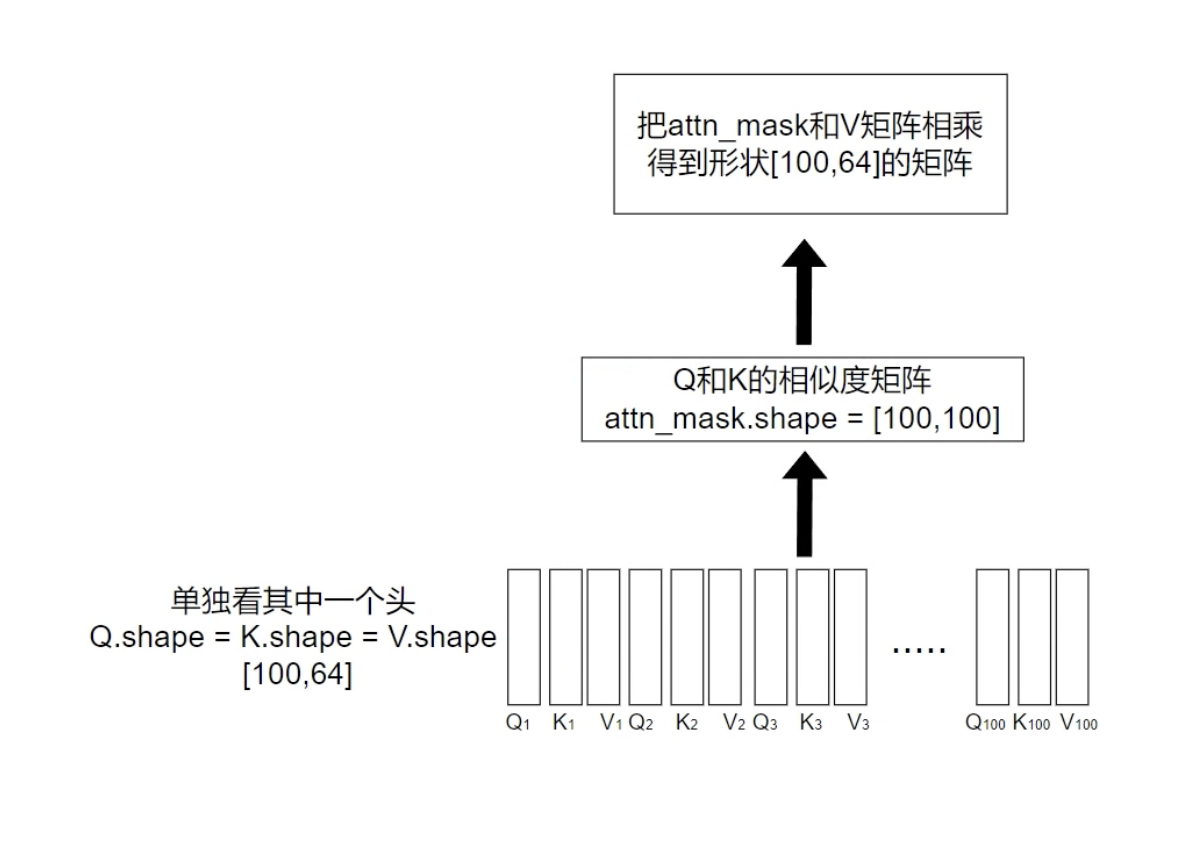

5.
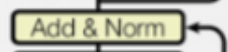

In [4]:
import json
import torch
import torch.utils.data as Data
from torch import nn, optim
import numpy as np
import time
from tqdm import tqdm

device = torch.device("cuda")
dict_datas = json.load(open('dict_datas.json', 'r'))
word2id, id2word = dict_datas['word2id'], dict_datas['id2word']
vocab_size = len(word2id)
max_pos = 1800
d_model = 768  # Embedding Size
d_ff = 2048  # FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_layers = 6  # number of Encoder of Decoder Layer
n_heads = 8  # number of heads in Multi-Head Attention
CLIP = 1

def make_data(datas):
    train_datas =[]
    for data in datas:
        data=data.strip()
        train_data = [i if i!='\t' else "<sep>" for i in data]+['<sep>']
        train_datas.append(train_data)

    return train_datas


class MyDataSet(Data.Dataset):
    def __init__(self,datas):
        self.datas = datas

    def __getitem__(self, item):
        data = self.datas[item]
        decoder_input = data[:-1]
        decoder_output = data[1:]

        decoder_input_len = len(decoder_input)
        decoder_output_len = len(decoder_output)

        return {"decoder_input":decoder_input,"decoder_input_len":decoder_input_len,
                "decoder_output":decoder_output,"decoder_output_len":decoder_output_len}

    def __len__(self):
        return len(self.datas)

    def padding_batch(self,batch):
        decoder_input_lens = [d["decoder_input_len"] for d in batch]
        decoder_output_lens = [d["decoder_output_len"] for d in batch]

        decoder_input_maxlen = max(decoder_input_lens)
        decoder_output_maxlen = max(decoder_output_lens)


        for d in batch:
            d["decoder_input"].extend([word2id["<pad>"]]*(decoder_input_maxlen-d["decoder_input_len"]))
            d["decoder_output"].extend([word2id["<pad>"]]*(decoder_output_maxlen-d["decoder_output_len"]))
        decoder_inputs = torch.tensor([d["decoder_input"] for d in batch],dtype=torch.long)
        decoder_outputs = torch.tensor([d["decoder_output"] for d in batch],dtype=torch.long)

        return decoder_inputs,decoder_outputs
## mask padding
def get_attn_pad_mask(seq_q, seq_k):
    '''
    seq_q: [batch_size, seq_len]
    seq_k: [batch_size, seq_len]
    seq_len could be src_len or it could be tgt_len
    seq_len in seq_q and seq_len in seq_k maybe not equal
    '''
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # [batch_size, 1, len_k], True is masked
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # [batch_size, len_q, len_k]

def get_attn_subsequence_mask(seq):
    '''
    seq: [batch_size, tgt_len]
    '''
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequence_mask = np.triu(np.ones(attn_shape), k=1) # Upper triangular matrix
    subsequence_mask = torch.from_numpy(subsequence_mask).byte()
    subsequence_mask=subsequence_mask.to(device)
    return subsequence_mask # [batch_size, tgt_len, tgt_len]

class ScaledDotProductAttention(nn.Module):
        def __init__(self):
            super(ScaledDotProductAttention, self).__init__()

        def forward(self, Q, K, V, attn_mask):
            '''
            Q: [batch_size, n_heads, len_q, d_k]
            K: [batch_size, n_heads, len_k, d_k]
            V: [batch_size, n_heads, len_v(=len_k), d_v]
            attn_mask: [batch_size, n_heads, seq_len, seq_len]
            '''
            scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(
                d_k)  # scores : [batch_size, n_heads, len_q, len_k]
            scores.masked_fill_(attn_mask, -1e9)  # Fills elements of self tensor with value where mask is True. ##### Mask

            attn = nn.Softmax(dim=-1)(scores)
            context = torch.matmul(attn, V)  # [batch_size, n_heads, len_q, d_v]
            return context, attn


class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias=False)
        self.fc = nn.Linear(n_heads * d_v, d_model, bias=False)
        self.layernorm = nn.LayerNorm(d_model)

    def forward(self, input_Q, input_K, input_V, attn_mask):
        '''
        input_Q: [batch_size, len_q, d_model]
        input_K: [batch_size, len_k, d_model]
        input_V: [batch_size, len_v(=len_k), d_model]
        attn_mask: [batch_size, seq_len, seq_len]
        '''
        residual, batch_size = input_Q, input_Q.size(0)
        # (B, S, D) -proj-> (B, S, D_new) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        Q = self.W_Q(input_Q).view(batch_size, -1, n_heads, d_k).transpose(1, 2)  # Q: [batch_size, n_heads, len_q, d_k]
        K = self.W_K(input_K).view(batch_size, -1, n_heads, d_k).transpose(1, 2)  # K: [batch_size, n_heads, len_k, d_k]
        V = self.W_V(input_V).view(batch_size, -1, n_heads, d_v).transpose(1,
                                                                           2)  # V: [batch_size, n_heads, len_v(=len_k), d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1,
                                                  1)  # attn_mask : [batch_size, n_heads, seq_len, seq_len]

        # context: [batch_size, n_heads, len_q, d_v], attn: [batch_size, n_heads, len_q, len_k]
        context, attn = ScaledDotProductAttention()(Q, K, V, attn_mask)
        context = context.transpose(1, 2).reshape(batch_size, -1,
                                                  n_heads * d_v)  # context: [batch_size, len_q, n_heads * d_v]
        output = self.fc(context)  # [batch_size, len_q, d_model]
        return self.layernorm(output + residual), attn





class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_pos,d_model)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs):
        '''
        dec_inputs: [batch_size, tgt_len]
        '''
        seq_len = dec_inputs.size(1)
        pos = torch.arange(seq_len, dtype=torch.long,device=device)
        pos = pos.unsqueeze(0).expand_as(dec_inputs)  # [seq_len] -> [batch_size, seq_len]
### input & pos embedding
        dec_outputs = self.tgt_emb(dec_inputs) + self.pos_emb(pos) # [batch_size, tgt_len, d_model]

        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs) # [batch_size, tgt_len, tgt_len]
        dec_self_attn_subsequence_mask = get_attn_subsequence_mask(dec_inputs)# [batch_size, tgt_len, tgt_len]
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequence_mask), 0) # [batch_size, tgt_len, tgt_len]



        dec_self_attns = []
        for layer in self.layers:
            # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len], dec_enc_attn: [batch_size, h_heads, tgt_len, src_len]
            dec_outputs, dec_self_attn = layer(dec_outputs, dec_self_attn_mask)
            dec_self_attns.append(dec_self_attn)

        return dec_outputs, dec_self_attns





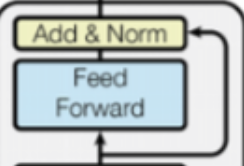

In [5]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_ff, bias=False),
            nn.ReLU(),
            nn.Linear(d_ff, d_model, bias=False)
        )
        self.layernorm=nn.LayerNorm(d_model)
    def forward(self, inputs):
        '''
        inputs: [batch_size, seq_len, d_model]
        '''
        residual = inputs
        output = self.fc(inputs)
        return self.layernorm(output + residual) # [batch_size, seq_len, d_model]

In [6]:

class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, dec_self_attn_mask):
        '''
        dec_inputs: [batch_size, tgt_len, d_model]
        dec_self_attn_mask: [batch_size, tgt_len, tgt_len]
        '''
        # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len]
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)

        dec_outputs = self.pos_ffn(dec_outputs)  # [batch_size, tgt_len, d_model]
        return dec_outputs, dec_self_attn

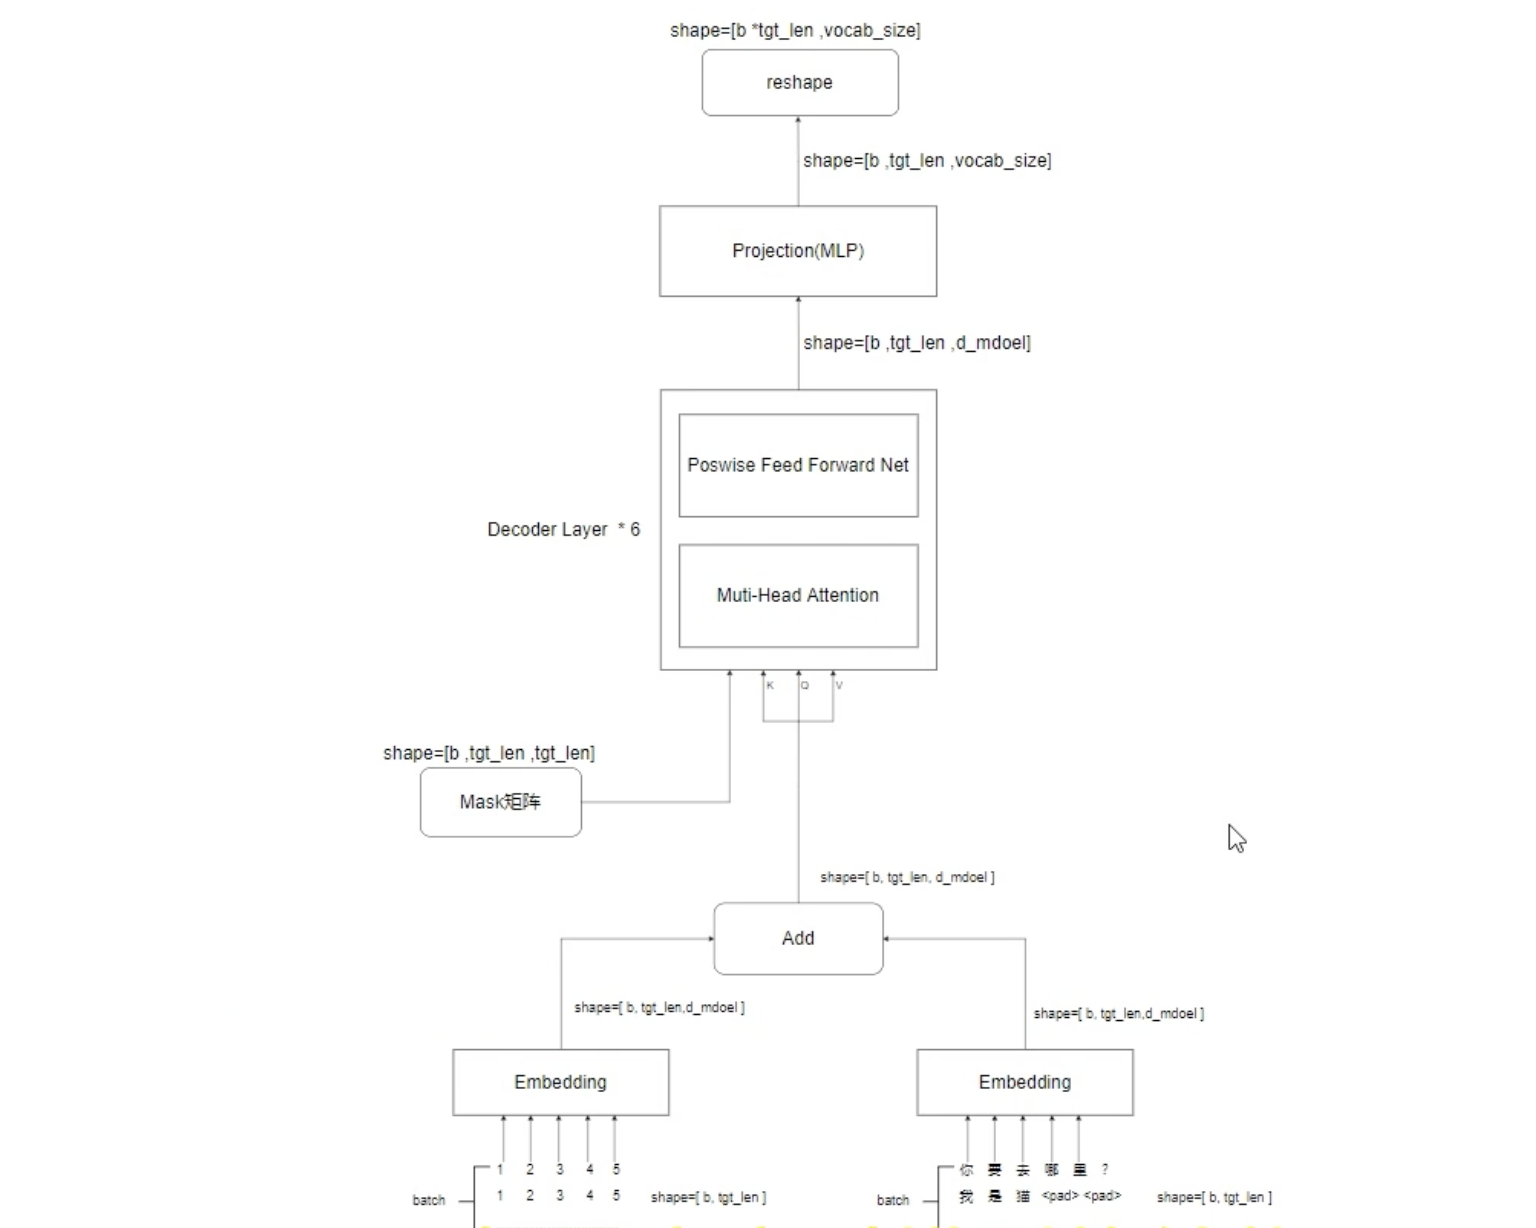

In [7]:
class GPT(nn.Module):
    def __init__(self):
        super(GPT, self).__init__()
        self.decoder = Decoder()
        self.projection = nn.Linear(d_model,vocab_size)
    def forward(self,dec_inputs):
        """
        dec_inputs: [batch_size, tgt_len],differnt batch can have differnt tgt_len because of layer norm, in same batch the tgt_len must be the same
        """

        # dec_outpus: [batch_size, tgt_len, d_model], dec_self_attns: [n_layers, batch_size, n_heads, tgt_len, tgt_len]
        dec_outputs, dec_self_attns = self.decoder(dec_inputs)
        # dec_logits: [batch_size, tgt_len, tgt_vocab_size]
        dec_logits = self.projection(dec_outputs)
        return dec_logits.view(-1, dec_logits.size(-1)), dec_self_attns

    def greedy_decoder(self,dec_input):

        terminal = False
        start_dec_len=len(dec_input[0])
        #一直预测下一个单词，直到预测到"<sep>"结束，如果一直不到"<sep>"，则根据长度退出循环，并在最后加上”<sep>“字符
        while not terminal :
            if len(dec_input[0])-start_dec_len>100:
                next_symbol=word2id['<sep>']
                dec_input = torch.cat(
                    [dec_input.detach(), torch.tensor([[next_symbol]], dtype=dec_input.dtype, device=device)], -1)
                break
            dec_outputs, _ = self.decoder(dec_input)
            projected = self.projection(dec_outputs)
            prob = projected.squeeze(0).max(dim=-1, keepdim=False)[1]
            next_word = prob.data[-1]
            next_symbol = next_word
            if next_symbol == word2id["<sep>"]:
                terminal = True

            dec_input = torch.cat(
                [dec_input.detach(), torch.tensor([[next_symbol]], dtype=dec_input.dtype, device=device)], -1)

        return dec_input

    def answer(self,sentence):
        #把原始句子的\t替换成”<sep>“
        dec_input = [word2id.get(word,1) if word!='\t' else word2id['<sep>'] for word in sentence]
        dec_input = torch.tensor(dec_input, dtype=torch.long, device=device).unsqueeze(0)

        output = self.greedy_decoder(dec_input).squeeze(0)
        out = [id2word[int(id)] for id in output]
        #统计"<sep>"字符在结果中的索引
        sep_indexs =[]
        for i in range(len(out)):
            if out[i] =="<sep>":
                sep_indexs.append(i)

        #取最后两个sep中间的内容作为回答

        answer = out[sep_indexs[-2]+1:-1]

        answer = "".join(answer)
        return answer

Train

In [9]:
import json
import torch
import torch.utils.data as Data
from torch import nn, optim
import numpy as np
import time
from tqdm import tqdm
# from gpt_model import *

def make_data(datas):
    train_datas =[]
    for data in datas: # each line
        data=data.strip()
        train_data = [i if i!='\t' else "<sep>" for i in data]+['<sep>'] # replace '/t' to <sep>
        train_datas.append(train_data)

    return train_datas


class MyDataSet(Data.Dataset):
    def __init__(self,datas):
        self.datas = datas

    def __getitem__(self, item):
        data = self.datas[item]
        decoder_input = data[:-1]
        decoder_output = data[1:] #right shift one position

        decoder_input_len = len(decoder_input)
        decoder_output_len = len(decoder_output)

        return {"decoder_input":decoder_input,"decoder_input_len":decoder_input_len,
                "decoder_output":decoder_output,"decoder_output_len":decoder_output_len}

    def __len__(self):
        return len(self.datas)

## for DataLoader,collate_fn param , in the batch the seq len is different so need to padding,
    def padding_batch(self,batch):
        decoder_input_lens = [d["decoder_input_len"] for d in batch]
        decoder_output_lens = [d["decoder_output_len"] for d in batch]

        decoder_input_maxlen = max(decoder_input_lens)
        decoder_output_maxlen = max(decoder_output_lens)


        for d in batch:
            d["decoder_input"].extend([word2id["<pad>"]]*(decoder_input_maxlen-d["decoder_input_len"])) # pad with <pad> index to the max len
            d["decoder_output"].extend([word2id["<pad>"]]*(decoder_output_maxlen-d["decoder_output_len"]))
        decoder_inputs = torch.tensor([d["decoder_input"] for d in batch],dtype=torch.long)
        decoder_outputs = torch.tensor([d["decoder_output"] for d in batch],dtype=torch.long)

        return decoder_inputs,decoder_outputs
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def train_step(model,data_loader,optimizer,criterion,clip=1,print_every=None):
    model.train()

    if print_every == 0:
        print_every = 1

    print_loss_total = 0  # 每次打印都重置

    epoch_loss = 0

    for i, (dec_inputs, dec_outputs) in enumerate(tqdm(data_loader)):
        '''
        dec_inputs: [batch_size, tgt_len]
        dec_outputs: [batch_size, tgt_len]
        '''
        optimizer.zero_grad()
        dec_inputs, dec_outputs =dec_inputs.to(device), dec_outputs.to(device)
        # outputs: [batch_size * tgt_len, tgt_vocab_size]
        outputs, dec_self_attns = model(dec_inputs)


        loss = criterion(outputs, dec_outputs.view(-1))
        print_loss_total += loss.item()
        epoch_loss += loss.item()
        loss.backward()


        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        if print_every and (i + 1) % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            # print('\tCurrent Loss: %.4f' % print_loss_avg)

    return epoch_loss / len(data_loader)

def train(model,data_loader):
    criterion = nn.CrossEntropyLoss(ignore_index=0).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        start_time = time.time()
        train_loss = train_step(model, data_loader, optimizer, criterion, CLIP, print_every=10)
        end_time = time.time()

        torch.save(model.state_dict(), 'GPT2.pt')

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')



def print_num_parameters(model):
    # Find total parameters and trainable parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(

        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} training parameters.')


with open('dataset.txt', 'r', encoding='utf-8') as f:
    datas = f.readlines()

train_data = make_data(datas) # train word --> list

train_num_data = [[word2id[word] for word in line] for line in train_data] # from setence to index(each word) [你好]-->[32,15]

batch_size = 8
epochs = 15
dataset = MyDataSet(train_num_data)
data_loader = Data.DataLoader(dataset, batch_size=batch_size, collate_fn=dataset.padding_batch) # no shuffle in this case, beacuese data is sorted, save computaion resource but with big bias
#####
#TODO: extract simillar seq len for each batch with shuffle
#####
model = GPT().to(device)

# model.load_state_dict(torch.load('GPT2.pt'))

train(model,data_loader)



100%|██████████| 1250/1250 [00:20<00:00, 60.22it/s]


Epoch: 01 | Time: 0m 20s
	Train Loss: 3.797


100%|██████████| 1250/1250 [00:20<00:00, 60.52it/s]


Epoch: 02 | Time: 0m 20s
	Train Loss: 3.056


100%|██████████| 1250/1250 [00:20<00:00, 60.38it/s]


Epoch: 03 | Time: 0m 20s
	Train Loss: 2.570


100%|██████████| 1250/1250 [00:20<00:00, 60.55it/s]


Epoch: 04 | Time: 0m 20s
	Train Loss: 2.058


100%|██████████| 1250/1250 [00:20<00:00, 59.73it/s]


Epoch: 05 | Time: 0m 20s
	Train Loss: 1.544


100%|██████████| 1250/1250 [00:20<00:00, 60.72it/s]


Epoch: 06 | Time: 0m 20s
	Train Loss: 1.115


100%|██████████| 1250/1250 [00:20<00:00, 60.14it/s]


Epoch: 07 | Time: 0m 20s
	Train Loss: 0.822


100%|██████████| 1250/1250 [00:20<00:00, 60.40it/s]


Epoch: 08 | Time: 0m 20s
	Train Loss: 0.656


100%|██████████| 1250/1250 [00:20<00:00, 59.92it/s]


Epoch: 09 | Time: 0m 20s
	Train Loss: 0.568


100%|██████████| 1250/1250 [00:20<00:00, 60.37it/s]


Epoch: 10 | Time: 0m 20s
	Train Loss: 0.514


100%|██████████| 1250/1250 [00:20<00:00, 60.06it/s]


Epoch: 11 | Time: 0m 20s
	Train Loss: 0.470


100%|██████████| 1250/1250 [00:20<00:00, 60.89it/s]


Epoch: 12 | Time: 0m 20s
	Train Loss: 0.441


100%|██████████| 1250/1250 [00:20<00:00, 60.72it/s]


Epoch: 13 | Time: 0m 20s
	Train Loss: 0.417


100%|██████████| 1250/1250 [00:20<00:00, 60.16it/s]


Epoch: 14 | Time: 0m 20s
	Train Loss: 0.397


100%|██████████| 1250/1250 [00:20<00:00, 59.68it/s]


Epoch: 15 | Time: 0m 20s
	Train Loss: 0.381
